Install the dependencies we will need for this notebook.

In [1]:
#import sys
#!{sys.executable} -m pip install pycountry_convert

import pandas as pd
import numpy as np

import geocoder
import requests
import json

import folium
import matplotlib.pyplot as plt

from scipy.cluster import hierarchy
import pylab
from sklearn.cluster import AgglomerativeClustering

from bs4 import BeautifulSoup as bs

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

Input the top 20 

In [2]:
top20 = ['Bangkok, Thailand',
         'Paris, France',
         'London, United Kingdom',
         'Dubai, United Arab Emirates',
         'Singapore, Singapore',
         'Kuala Lumpur, Malaysia',
         'New York City, United States',
         'Istanbul, Turkey',
         'Tokyo, Japan',
         'Antalya, Turkey',
         'Seoul, South Korea',
         'Osaka, Japan',
         'Mecca, Saudi Arabia',
         'Phuket, Thailand',
         'Phatthaya, Thailand',
         'Milan, Italy',
         'Barcelona, Spain',
         'Palma, Spain',
         'Bali, Indonesia',
         'Hong Kong, Hong Kong SAR China']
top20_split = [top.split(', ') for top in top20]
top20_split

[['Bangkok', 'Thailand'],
 ['Paris', 'France'],
 ['London', 'United Kingdom'],
 ['Dubai', 'United Arab Emirates'],
 ['Singapore', 'Singapore'],
 ['Kuala Lumpur', 'Malaysia'],
 ['New York City', 'United States'],
 ['Istanbul', 'Turkey'],
 ['Tokyo', 'Japan'],
 ['Antalya', 'Turkey'],
 ['Seoul', 'South Korea'],
 ['Osaka', 'Japan'],
 ['Mecca', 'Saudi Arabia'],
 ['Phuket', 'Thailand'],
 ['Phatthaya', 'Thailand'],
 ['Milan', 'Italy'],
 ['Barcelona', 'Spain'],
 ['Palma', 'Spain'],
 ['Bali', 'Indonesia'],
 ['Hong Kong', 'Hong Kong SAR China']]

In [3]:
top20_df = pd.DataFrame(top20_split)
top20_df.columns = ['City', 'Country']
top20_df

,City,Country
0,Bangkok,Thailand
1,Paris,France
2,London,United Kingdom
3,Dubai,United Arab Emirates
4,Singapore,Singapore
5,Kuala Lumpur,Malaysia
6,New York City,United States
7,Istanbul,Turkey
8,Tokyo,Japan
9,Antalya,Turkey


use for loop to get data for top 20 cities

In [4]:
lat = []
lng = []
for city in top20:
    g = geocoder.arcgis(city)
    latlng = g.latlng
    lat.append(latlng[0])
    lng.append(latlng[1])
top20_df['Latitude'] = lat
top20_df['Longitude'] = lng
top20_df

,City,Country,Latitude,Longitude
0,Bangkok,Thailand,13.753360,100.504830
1,Paris,France,48.857170,2.341400
2,London,United Kingdom,51.506420,-0.127210
3,Dubai,United Arab Emirates,25.269510,55.308840
4,Singapore,Singapore,1.290410,103.852110
5,Kuala Lumpur,Malaysia,3.147890,101.694050
6,New York City,United States,40.714550,-74.007140
7,Istanbul,Turkey,41.013840,28.949660
8,Tokyo,Japan,35.689456,139.691716
9,Antalya,Turkey,36.878950,30.709230


ask how many cities the user would like to enter

In [5]:
num_user_inputs = input('How many cities would you like to compare to the top 20 visited cities of 2018?')

How many cities would you like to compare to the top 20 visited cities of 2018? 5


loop through, getting input of cities (or areas/addresses) for number of cities user wants to add

In [6]:
input_list = []
for i in range(int(num_user_inputs)):
    city = input('Enter the city you would like to compare (in the form City, Country): ')
    g = geocoder.arcgis(city)
    split_city = city.split(', ')
    if split_city[1] == 'USA':
        split_city[1] = 'United States'
    input_list.append([split_city[0], split_city[1], g.latlng[0], g.latlng[1]])
user_inputs = pd.DataFrame(input_list, columns = ['City', 'Country', 'Latitude', 'Longitude'])
user_inputs

Enter the city you would like to compare (in the form City, Country):  Honolulu, USA
Enter the city you would like to compare (in the form City, Country):  Sydney, Australia
Enter the city you would like to compare (in the form City, Country):  Los Angeles, USA
Enter the city you would like to compare (in the form City, Country):  Toronto, Canada
Enter the city you would like to compare (in the form City, Country):  Rio de Janeiro, Brazil


,City,Country,Latitude,Longitude
0,Honolulu,United States,21.30493,-157.85788
1,Sydney,Australia,-33.86960,151.20691
2,Los Angeles,United States,34.05361,-118.24550
3,Toronto,Canada,43.64869,-79.38544
4,Rio de Janeiro,Brazil,-22.91216,-43.17501


combine top 20 and user input cities into one df

In [7]:
all_cities = top20_df.merge(user_inputs, how = 'outer')
all_cities

,City,Country,Latitude,Longitude
0,Bangkok,Thailand,13.753360,100.504830
1,Paris,France,48.857170,2.341400
2,London,United Kingdom,51.506420,-0.127210
3,Dubai,United Arab Emirates,25.269510,55.308840
4,Singapore,Singapore,1.290410,103.852110
5,Kuala Lumpur,Malaysia,3.147890,101.694050
6,New York City,United States,40.714550,-74.007140
7,Istanbul,Turkey,41.013840,28.949660
8,Tokyo,Japan,35.689456,139.691716
9,Antalya,Turkey,36.878950,30.709230


In [8]:
website = 'https://weatherspark.com'
baseurl = website + '/countries'
soup = bs(requests.get(baseurl).content)
city_weather_url = []
for i, city, country in zip(all_cities.index, all_cities['City'], all_cities['Country']):
    try:    
        country_path = soup.find("a", text = f"{country}")['href'] # row['Country']
        url = website + country_path
        while ('/y/' not in url):
            newsoup = bs(requests.get(url).content)
            match = newsoup.find("a", text = f"{city}")
            if match.find_parents(name='ul', attrs={"class":"breadcrumb"}) != []:
                match = match.findNext(name='a', text = f"{city}")
            path = match['href']
            url = website + path
    except: # likely due to specifications that will hardly alter weather patterns (need to specify district, etc)
        path = newsoup.find("a", attrs={"class":"ListPage-featured"})['href']
        url = website + path
    city_weather_url.append([city, url])

In [9]:
city_weather_url_df = pd.DataFrame(city_weather_url)
city_weather_url_df.columns = ['City', 'url']

In [10]:
weather_avgs = []
for city, url in zip(city_weather_url_df['City'], city_weather_url_df['url']):
    soup = bs(requests.get(url).content)
    Jan_url = soup.find("a", text = "Jan")['href']
    month_urls = [Jan_url.replace('/1/', '/{}/').format(i + 1) for i in range(12)]
    city_weather = [city]
    for i in range(len(month_urls)):
        month_url = website + month_urls[i]
        soup = bs(requests.get(month_url).content)
        figure = soup.find("h2", attrs={"class":"Figure-title"})
        highs = figure.find_next_siblings("div", attrs={"class":"Figure-chart"})[0].findAll("g", attrs={"stroke-linejoin":"bevel"})
        lows = figure.find_next_siblings("div", attrs={"class":"Figure-chart"})[0].findAll("text", attrs={"stroke-linejoin":"bevel", "text-anchor":"middle"})

        tot_high = 0
        tot_low = 0
        for j in range(len(lows)):
            tot_low += int(lows[j].text.strip('°F'))
            for high in highs[j]:
                try:
                    tot_high += int(high.text.strip('°F'))
                except:
                    pass
        avg_high = round(tot_high / (j+1), 2)
        avg_low = round(tot_low / (j+1), 2)
        city_weather.extend([avg_high, avg_low])

    weather_avgs.append(city_weather)

In [11]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
columns = ['City']
for month in months:
    columns.extend([f"{month} High", f"{month} Low"])
city_weather_df = pd.DataFrame(weather_avgs)
city_weather_df.columns = columns
city_weather_df.head()

,City,Jan High,Jan Low,Feb High,Feb Low,Mar High,Mar Low,Apr High,Apr Low,May High,...,Aug High,Aug Low,Sep High,Sep Low,Oct High,Oct Low,Nov High,Nov Low,Dec High,Dec Low
0,Bangkok,89.00,72.00,91.00,75.00,93.00,78.00,94.67,80.00,93.75,...,91.00,79.00,90.33,78.33,89.25,77.50,89.00,75.67,88.33,72.33
1,Paris,44.50,36.00,46.67,36.00,52.75,39.25,59.00,43.25,66.00,...,75.33,57.33,70.00,53.67,61.00,47.25,52.00,41.33,45.75,37.00
2,London,47.33,39.33,47.67,39.33,51.75,41.50,57.50,44.75,63.25,...,72.25,59.00,67.33,55.00,59.75,50.00,53.33,44.67,48.75,40.75
3,Dubai,75.67,57.67,77.67,59.33,84.00,63.75,92.50,69.75,100.25,...,105.25,85.25,102.00,81.33,95.25,74.50,87.00,68.00,78.50,61.25
4,Singapore,86.25,76.75,88.00,77.00,89.00,77.75,89.00,78.67,89.00,...,87.50,78.75,87.67,78.00,88.00,78.00,87.00,77.00,86.25,77.00


In [12]:
avg_lat = all_cities['Latitude'].mean()
avg_lng = all_cities['Longitude'].mean()
world_map = folium.Map(location = [avg_lat, avg_lng], zoom_start = 2)

for i, lat, lng, label in zip(all_cities.index, all_cities['Latitude'], all_cities['Longitude'], all_cities['City']):
    city = folium.Popup(label, parse_html = True)
    # The top 20 cities will be blue and range in radius size from 5 to 10
    if i < 20:
        rad = np.linspace(10, 5, num = 20)[i]
        col = 'blue'
    # The input cities will be red and have radius 4
    else:
        rad = 4
        col = 'red'
    folium.CircleMarker([lat, lng],
                        radius = rad,
                        popup = city,
                        color = col,
                        fill = True,
                        fill_color = col,
                        fill_opacity = 0.6,
                        parse_html = False).add_to(world_map)

world_map

In [14]:
from credentials import foursquare

In [15]:
client_id = foursquare['id']
client_secret = foursquare['secret']
version = '20201201'
limit = 100

In [16]:
venues_list = []
for city, lat, lng in zip(all_cities['City'], all_cities['Latitude'], all_cities['Longitude']):
    # Create API request url to get venue data for each city
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&limit={}&time=any&day=any&sortByPopularity=1'.format(
            client_id,
            client_secret,
            version,
            lat,
            lng,
            limit)
    
    results = requests.get(url).json()['response']['groups'][0]['items']
    
    for venue in results:
        venues_list.append([
            city,
            lat,
            lng,
            venue['venue']['name'],
            venue['venue']['categories'][0]['name'],
            venue['venue']['id']
        ])

venues_df = pd.DataFrame(venues_list)
venues_df.columns = ['City', 'Latitude', 'Longitude', 'Venue Name', 'Venue Category', 'Venue ID']

venues_df.head()

,City,Latitude,Longitude,Venue Name,Venue Category,Venue ID
0,Bangkok,13.75336,100.50483,Mont Nom Sod (มนต์นมสด),Bakery,4bd44d2d046076b0aa987771
1,Bangkok,13.75336,100.50483,Thip Samai (ทิพย์สมัย (ผัดไทยประตูผี)),Noodle House,4c2f7415452620a1b4851d0f
2,Bangkok,13.75336,100.50483,Romaneenart Park (สวนรมณีนาถ),Park,4c1c8b0eb9f876b0521b7c46
3,Bangkok,13.75336,100.50483,Cheng Sim Ei (เช็งซิมอี๊),Dessert Shop,5544b71c498e2e2bf2c9f8d0
4,Bangkok,13.75336,100.50483,Krua Apsorn (ครัวอัปษร),Thai Restaurant,4bd2ca90046076b0259a7471


In [17]:
onehot_venues = pd.get_dummies(venues_df['Venue Category'])
onehot_venues['City'] = venues_df['City']
col_order = [onehot_venues.columns[-1]] + list(onehot_venues.columns[:-1])
onehot_venues = onehot_venues[col_order]
onehot_venues.head()

,City,ATM,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,...,Vietnamese Restaurant,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Bangkok,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bangkok,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bangkok,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bangkok,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bangkok,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
venues_grouped = onehot_venues.groupby('City').mean().reset_index()
venues_grouped.head()

,City,ATM,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,...,Vietnamese Restaurant,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Antalya,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.020000,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
1,Bali,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.03125,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
2,Bangkok,0.0,0.00,0.0,0.016393,0.0,0.0,0.0,0.016393,0.016393,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
3,Barcelona,0.0,0.01,0.0,0.010000,0.0,0.0,0.0,0.010000,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00,0.02,0.0
4,Dubai,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.020000,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.02,0.00,0.0


In [19]:
min_max_scaler = MinMaxScaler()
normalized_weather = min_max_scaler.fit_transform(city_weather_df.iloc[:,1:].values)
normalized_weather_df = pd.DataFrame(normalized_weather)
normalized_weather_df['City'] = city_weather_df['City']
cols = ['City'] + normalized_weather_df.columns[:-1].tolist()
normalized_weather_df = normalized_weather_df[cols]
normalized_weather_df.head()

,City,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,Bangkok,0.995781,0.914163,1.000000,0.965320,1.000000,0.976190,0.949348,0.971591,0.774390,...,0.640244,0.826389,0.621622,0.892857,0.763006,0.985294,0.928633,0.945814,0.996808,0.895769
1,Paris,0.244726,0.296137,0.261167,0.289058,0.254630,0.238095,0.173913,0.136364,0.097561,...,0.258049,0.224444,0.072162,0.012143,0.109827,0.095588,0.135662,0.147209,0.197183,0.216346
2,London,0.292489,0.353305,0.277833,0.346801,0.236111,0.280952,0.141304,0.170455,0.030488,...,0.182927,0.270833,0.000000,0.059643,0.080925,0.176471,0.164166,0.224884,0.253521,0.288462
3,Dubai,0.770802,0.668155,0.777833,0.693602,0.833333,0.704762,0.902174,0.738636,0.932927,...,0.987805,1.000000,0.937027,1.000000,0.901734,0.897059,0.885769,0.767442,0.812207,0.682692
4,Singapore,0.949367,0.995708,0.950000,1.000000,0.925926,0.971429,0.826087,0.941364,0.658537,...,0.554878,0.819444,0.549730,0.881071,0.734104,1.000000,0.885769,0.976744,0.957746,0.985577


Combine venues dataframe with weather dataframe to prepare for clustering

In [20]:
cities_grouped = normalized_weather_df.join(venues_grouped.set_index('City'), on = 'City')
cities_grp_clustering = cities_grouped.drop('City', 1)
cities_grp_clustering.head()

,0,1,2,3,4,5,6,7,8,9,...,Vietnamese Restaurant,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0.995781,0.914163,1.000000,0.965320,1.000000,0.976190,0.949348,0.971591,0.774390,0.970370,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0
1,0.244726,0.296137,0.261167,0.289058,0.254630,0.238095,0.173913,0.136364,0.097561,0.059259,...,0.0,0.0,0.00,0.0,0.02,0.01,0.00,0.00,0.00,0.0
2,0.292489,0.353305,0.277833,0.346801,0.236111,0.280952,0.141304,0.170455,0.030488,0.074074,...,0.0,0.0,0.00,0.0,0.02,0.00,0.00,0.00,0.00,0.0
3,0.770802,0.668155,0.777833,0.693602,0.833333,0.704762,0.902174,0.738636,0.932927,0.837037,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.02,0.00,0.0
4,0.949367,0.995708,0.950000,1.000000,0.925926,0.971429,0.826087,0.941364,0.658537,0.933333,...,0.0,0.0,0.01,0.0,0.00,0.01,0.01,0.00,0.01,0.0


In [21]:
from sklearn.metrics.pairwise import euclidean_distances
dist_matrix = euclidean_distances(cities_grp_clustering, cities_grp_clustering)
dist_matrix.shape

(25, 25)

In [22]:
Z = hierarchy.linkage(dist_matrix, 'complete', optimal_ordering=True)

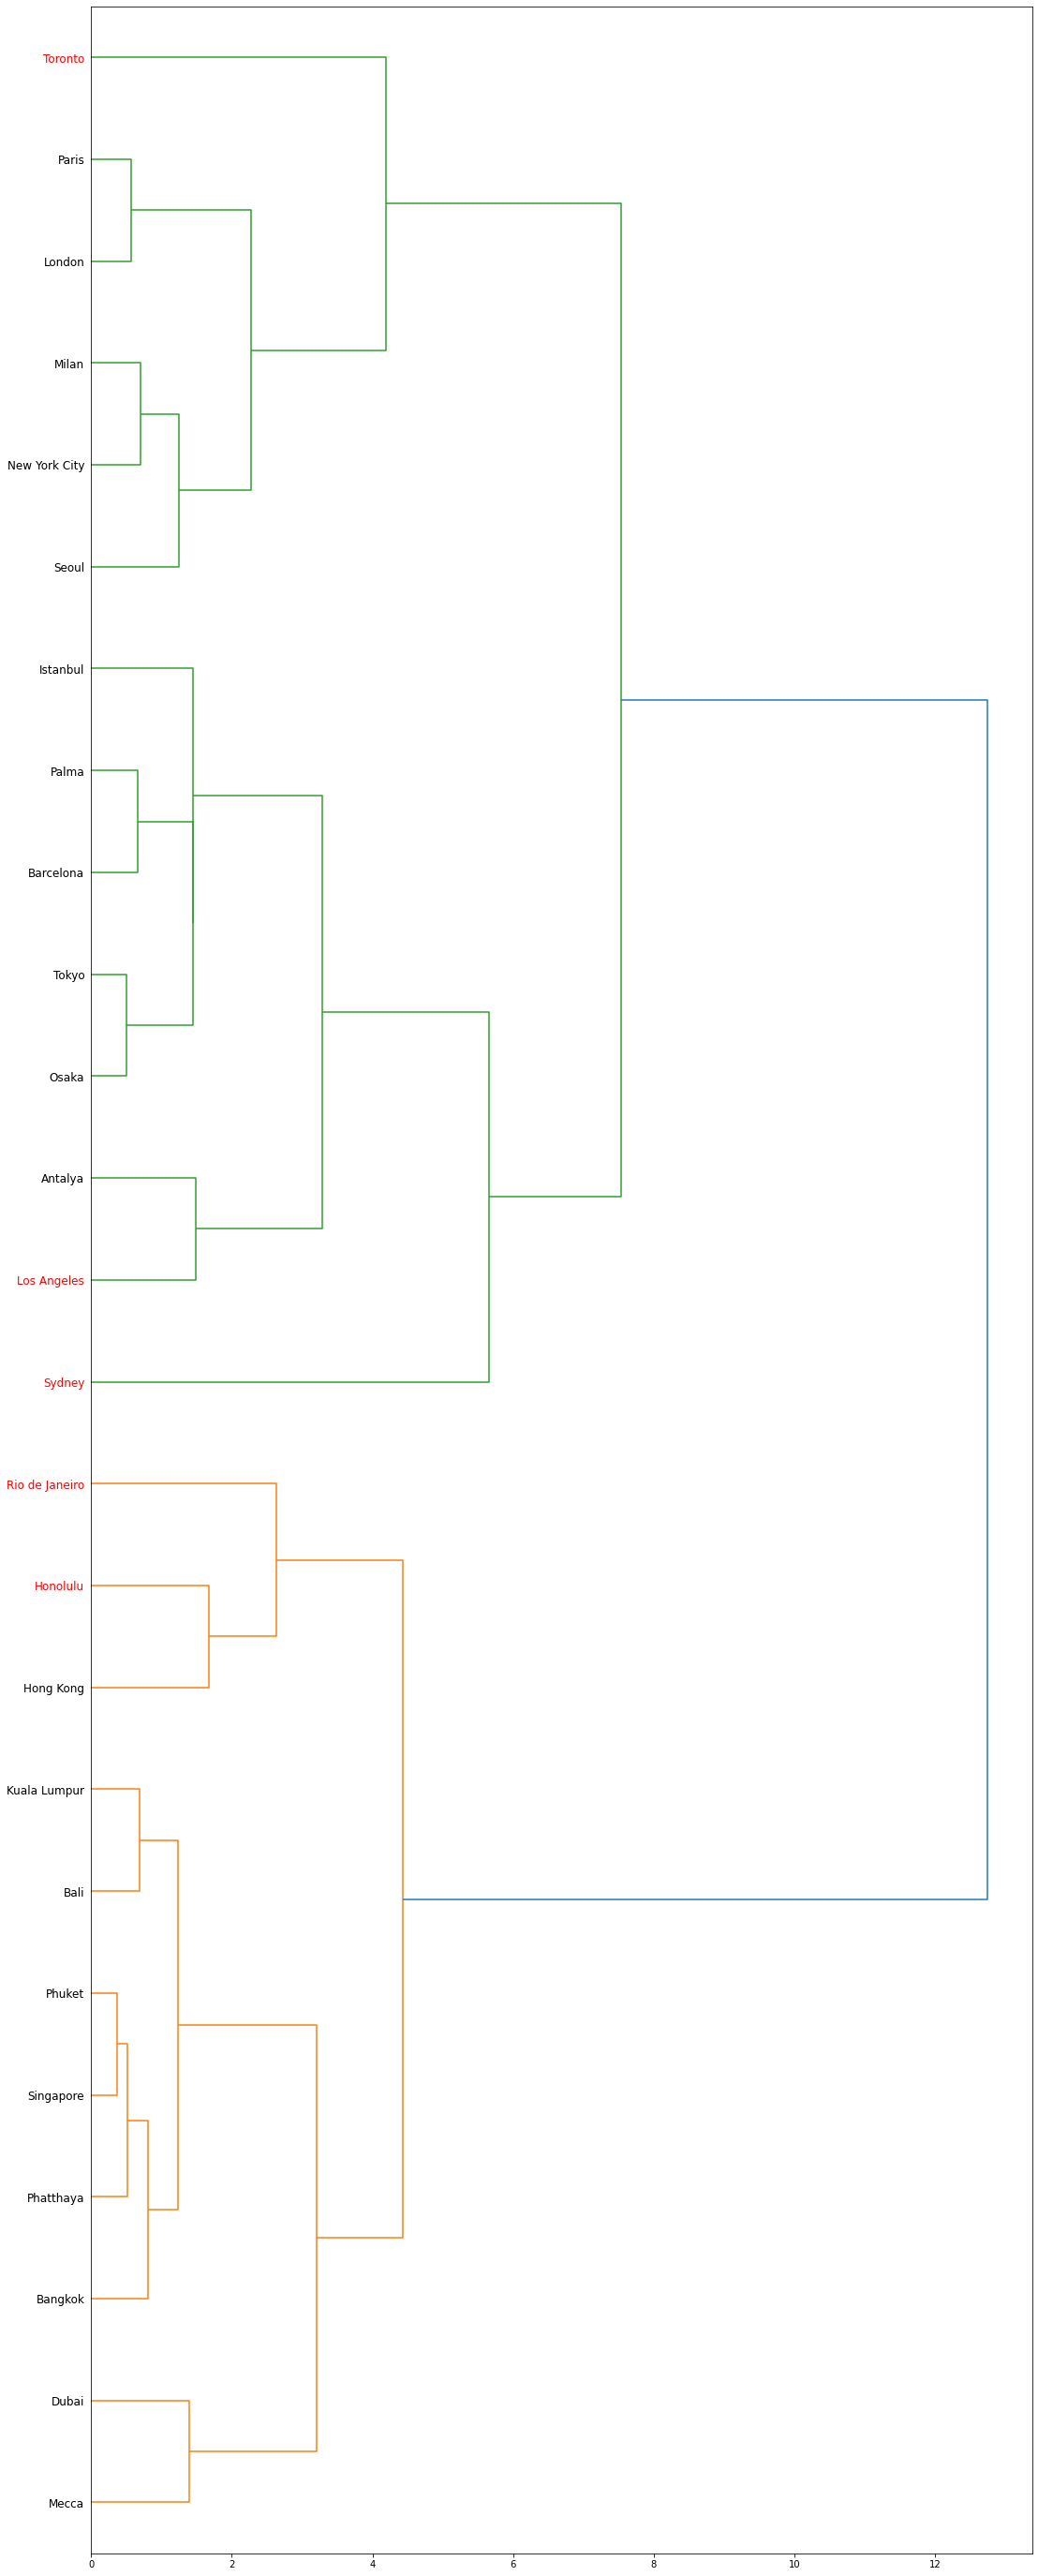

In [23]:
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return cities_grouped['City'][id]
    
dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

ax = plt.gca()
ylbls = ax.get_ymajorticklabels()
for lbl in ylbls:
    ## 
    if lbl.get_text() in all_cities[all_cities['City'].index >= 20]['City'].values:
        lbl.set_color('r')

plt.show()

map heirarchical cluster of them (maybe highlight user input w closest cities (different color for each user input idk)

In [26]:
agglom = AgglomerativeClustering(n_clusters = 5, linkage = 'complete', compute_distances=True)
agglom.fit(dist_matrix)

agglom.labels_

array([2, 0, 0, 2, 2, 2, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 1, 1, 2, 4, 4, 3,
       1, 0, 4])

In [27]:
agglom.distances_

array([ 0.37244394,  0.4977472 ,  0.51753302,  0.57263271,  0.66586691,
        0.68573373,  0.69726692,  0.80513623,  1.23774563,  1.2528199 ,
        1.39075345,  1.44412834,  1.44834019,  1.48990326,  1.67046274,
        2.27089016,  2.63682136,  3.19906737,  3.28291834,  4.18898513,
        4.43172656,  5.65306983,  7.53787411, 12.74012834])

In [28]:
cities_grouped['cluster'] = agglom.labels_
cities_grouped

,City,0,1,2,3,4,5,6,7,8,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,cluster
0,Bangkok,0.995781,0.914163,1.000000,0.965320,1.000000,0.976190,0.949348,0.971591,0.774390,...,0.00000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.0000,0.0000,2
1,Paris,0.244726,0.296137,0.261167,0.289058,0.254630,0.238095,0.173913,0.136364,0.097561,...,0.00000,0.00,0.000000,0.020000,0.01,0.00,0.00,0.0000,0.0000,0
2,London,0.292489,0.353305,0.277833,0.346801,0.236111,0.280952,0.141304,0.170455,0.030488,...,0.00000,0.00,0.000000,0.020000,0.00,0.00,0.00,0.0000,0.0000,0
3,Dubai,0.770802,0.668155,0.777833,0.693602,0.833333,0.704762,0.902174,0.738636,0.932927,...,0.00000,0.00,0.000000,0.000000,0.00,0.00,0.02,0.0000,0.0000,2
4,Singapore,0.949367,0.995708,0.950000,1.000000,0.925926,0.971429,0.826087,0.941364,0.658537,...,0.00000,0.01,0.000000,0.000000,0.01,0.01,0.00,0.0100,0.0000,2
5,Kuala Lumpur,1.000000,0.939914,0.994500,0.947980,0.962963,0.912762,0.869565,0.863636,0.707317,...,0.00000,0.00,0.000000,0.010000,0.00,0.00,0.00,0.0000,0.0000,2
6,New York City,0.168776,0.175966,0.188833,0.179296,0.208333,0.185714,0.217391,0.204545,0.213415,...,0.00000,0.00,0.000000,0.010000,0.00,0.00,0.00,0.0100,0.0000,0
7,Istanbul,0.295359,0.343348,0.277833,0.329461,0.250000,0.276190,0.217391,0.244318,0.195122,...,0.00000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.0000,0.0000,1
8,Tokyo,0.316456,0.309013,0.305500,0.312121,0.296296,0.304762,0.293478,0.340909,0.243902,...,0.00000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.0000,0.0000,1
9,Antalya,0.478143,0.404807,0.472167,0.404716,0.462963,0.361905,0.423913,0.335227,0.390244,...,0.00000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.0000,0.0000,1


In [29]:
cities_grouped.groupby('cluster').count()

,City,0,1,2,3,4,5,6,7,8,...,Vietnamese Restaurant,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
cluster,,,,,,,,,,,,,,,,,,,,,
0,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
1,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
2,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [35]:
for i in range(max(cities_grouped['cluster']) + 1):
    print('Cluster ' + str(i))
    display(all_cities.loc[cities_grouped['cluster'] == i, :])

Cluster 0


,City,Country,Latitude,Longitude
1,Paris,France,48.85717,2.34140
2,London,United Kingdom,51.50642,-0.12721
6,New York City,United States,40.71455,-74.00714
10,Seoul,South Korea,37.56826,126.97783
15,Milan,Italy,45.46796,9.18178
23,Toronto,Canada,43.64869,-79.38544


Cluster 1


,City,Country,Latitude,Longitude
7,Istanbul,Turkey,41.013840,28.949660
8,Tokyo,Japan,35.689456,139.691716
9,Antalya,Turkey,36.878950,30.709230
11,Osaka,Japan,34.693726,135.502162
16,Barcelona,Spain,41.388040,2.170010
17,Palma,Spain,39.571480,2.646940
22,Los Angeles,United States,34.053610,-118.245500


Cluster 2


,City,Country,Latitude,Longitude
0,Bangkok,Thailand,13.753360,100.504830
3,Dubai,United Arab Emirates,25.269510,55.308840
4,Singapore,Singapore,1.290410,103.852110
5,Kuala Lumpur,Malaysia,3.147890,101.694050
12,Mecca,Saudi Arabia,21.421110,39.822220
13,Phuket,Thailand,7.890197,98.398584
14,Phatthaya,Thailand,12.949373,100.892905
18,Bali,Indonesia,-8.369744,115.131652


Cluster 3


,City,Country,Latitude,Longitude
21,Sydney,Australia,-33.8696,151.20691


Cluster 4


,City,Country,Latitude,Longitude
19,Hong Kong,Hong Kong SAR China,22.27830,114.16039
20,Honolulu,United States,21.30493,-157.85788
24,Rio de Janeiro,Brazil,-22.91216,-43.17501
